Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph

categories:[multimodal learning, deep learning, Transformer, Graph]

Motivation
In the article 'Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph', the MMFDL model is used for predicting drug properties. We tested the model using six single-molecule datasets, including Delaney, Llinas2020, Lipophilicity, SAMPL, BACE and pKa from DataWarrior. 
In this post, we use the SAMPL dataset for how to train MMFDL model. The input of the model is to convert drug molecules into three molecular representations: SMILES-encoed vectors、ECFP fingerprints and molecular graphs. To process the modal nformation, Transformer-Ecoder、BiGRU and graph convolutional network(GCN) are utilized for feature learning respectively. Then this model uses five fusion methods to capture specific features.

I'll use SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset fro protein and ligand modeling and consists of 642 experimental values logP.

Let's take the SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset for protein and ligand modeling and consists of 642 experimental values logP.

MMFDL_singleGCN.ipynb is a single GCN model.

Prepare training data and testing data.

In [1]:
# from myTrCPI.script.makeModel.utils_smiecfp import *
from sklearn import metrics
# from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import InMemoryDataset, DataLoader
# from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import warnings
import pickle
import sys
sys.path.append('../util')
from utils_smiecfp import *
from data_gen_modify import *
from analysis import *
from utils import *

sys.path.append('../model')
from model_trans_bigru_gcn import modelGcn


gpu_index = 0  # 可以根据需要更改为其他 GPU 编号

# 检查是否有可用的 GPU 设备
if torch.cuda.is_available():
    # 设置为指定的 GPU 设备
    device = torch.device(f'cuda:{gpu_index}')
else:
    # 如果没有可用的 GPU，使用 CPU
    device = torch.device('cpu')


epochs = 50
batch_size = 16
label = 1000
random_state=42

argsGcn = {
    'n_output': 1,
    'num_features': 78,
    'output_dim': 128,
    'dropout': 0.1, 
}



resultLoss = {'losses_train': [], 'losses_val': []}

train_data = formDataset(root='../dataSour', dataset='data_train')
train_ratio = 0.8
num_data = len(train_data)
indices = list(range(num_data))
train_indices, val_indices = train_test_split(indices, train_size=train_ratio, shuffle=True, random_state=random_state)
train_dataset = [train_data[i] for i in train_indices]
val_dataset = [train_data[i] for i in val_indices]
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_data = formDataset(root='../dataSour', dataset='data_test')
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Pre-processed data found: ../dataSour/processed/data_train.pt, loading ...
Pre-processed data found: ../dataSour/processed/data_test.pt, loading ...


/home/bioinfor3/.conda/envs/lxh-TransFM3/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


The input to BiGRU is graph, includes adjacency matrix and eigenvectors.

In [2]:
learning_rate = 0.0001
model = modelGcn(argsGcn).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

model.train()
for i in range(epochs):
    print("Running EPOCH",i+1)
    total_loss = 0
    n_batches = 0
    correct = 0
    '''
        train部分
    '''
    for batch_idx, data in enumerate(trainLoader):
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        y =data.y.to(device)
        y_pred = model(x, edge_index, batch)
        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(), y.type(torch.DoubleTensor))
        total_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        n_batches+=1
    avg_loss = total_loss / n_batches
    resultLoss['losses_train'].append(avg_loss)
    print('train avg_loss is: ', avg_loss.item())

    '''
        val部分
    '''
    total_loss = 0
    n_batches = 0
    correct = 0
    for batch_idx, data in enumerate(valLoader):
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        y =data.y.to(device)
        y_pred = model(x, edge_index, batch)   
        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(), y.type(torch.DoubleTensor))
        total_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        n_batches+=1
    avg_loss = total_loss / n_batches
    resultLoss['losses_val'].append(avg_loss) 
    print('val avg_loss is: ', avg_loss.item())
    print('\n')



y_pred_list = []
y_sour_list = []
correct = 0


model.eval()
for batch_idx, data in enumerate(testLoader):
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)
    y =data.y.to(device)
    y_pred = model(x, edge_index, batch)  
    y_pred_list.append(y_pred.squeeze().tolist())
    y_sour_list.append(y.tolist())

y_pred = []
for data in y_pred_list:
    for item in data:
        value = round(item, 2)
        y_pred.append(value)

y = []
for data in y_sour_list:
    for item in data:
        value = round(item, 2)
        y.append(value)

yResult = {}
ground_truth = np.array(y)
predictions = np.array(y_pred)
# calculate rmse
squared_errors = (ground_truth - predictions) ** 2
rmse = np.sqrt(np.mean(squared_errors))
yResult['rmse'] = rmse
# calculate mae
absolute_errors = np.abs(ground_truth - predictions)
mae = np.mean(absolute_errors)
yResult['mae'] = mae
print(yResult)

Running EPOCH 1
train avg_loss is:  28.372693819829575
val avg_loss is:  21.40235054470396


Running EPOCH 2
train avg_loss is:  26.68872848288825
val avg_loss is:  18.765427262951963


Running EPOCH 3
train avg_loss is:  22.890931887577235
val avg_loss is:  16.81307812839364


Running EPOCH 4
train avg_loss is:  19.251459048481767
val avg_loss is:  13.329374671845382


Running EPOCH 5
train avg_loss is:  17.03471085447016
val avg_loss is:  11.204732507192274


Running EPOCH 6
train avg_loss is:  14.01271216563252
val avg_loss is:  10.58957907304771


Running EPOCH 7
train avg_loss is:  13.670448873342098
val avg_loss is:  10.464951701863212


Running EPOCH 8
train avg_loss is:  13.106375598630477
val avg_loss is:  10.501713525316962


Running EPOCH 9
train avg_loss is:  12.972778822593032
val avg_loss is:  10.485606548328333


Running EPOCH 10
train avg_loss is:  12.960443662611896
val avg_loss is:  10.27655275077422


Running EPOCH 11
train avg_loss is:  12.618672345892293
val avg_lo

Save results

pearson:  (0.6872688654289635, 5.352218150223084e-14)
0.6644232888922921 0.6872688654289638


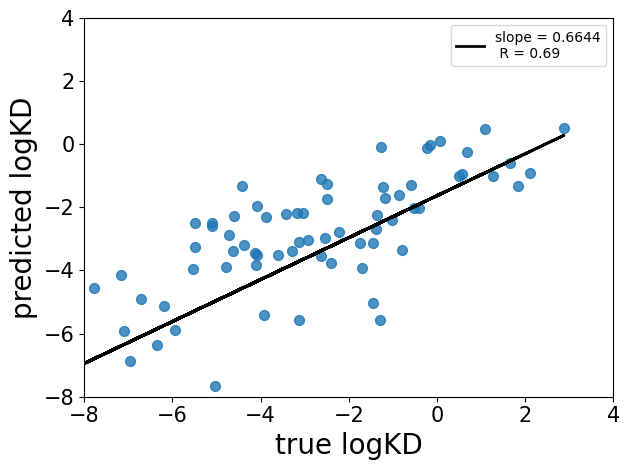



../result/1000-result-16-50-42-gcn.csv	saved successfully


: 

In [3]:
savePath = '../result/{}_rmseMae_{}_{}_{}_gcn.csv'.format(label, batch_size, epochs, random_state)
rmseAndMae(yResult, savePath)


savePath = '../result/{}_scatter_predited_{}_{}_{}_gcn.png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(y_pred, y, savePath)
print('\n')

result = {}
result['y_pred'] = y_pred
result['y'] = y
resultPath = '../result/{}-result-{}-{}-{}-gcn.csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')

savePath = '../result/{}_loss_{}_{}_{}_gcn.png'.format(label, batch_size, epochs, random_state)

savePath = '../result/{}_loss_{}_{}_{}_gcn.csv'.format(label, batch_size, epochs, random_state)
lossDf = pd.DataFrame(resultLoss)
lossDf.to_csv(savePath, index=False)
